In [14]:
! pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from tensorflow.keras.utils import plot_model
from sklearn import metrics
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline 

In [3]:
# Read Train and Test dataset
data_train = pd.read_csv("KDDTrain.txt")

In [4]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])
# Assign name for columns
data_train.columns = columns

In [5]:
data_train.loc[data_train['outcome'] != 'normal', 'outcome'] = 'attack'


In [6]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

In [7]:
cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)
    
    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]
    
    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1
    
    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

In [8]:
scaled_train = preprocess(data_train)

In [9]:
x = scaled_train.drop(['outcome', 'level'] , axis = 1).values
y = scaled_train['outcome'].values
y_reg = scaled_train['level'].values

pca = PCA(n_components=20)
pca = pca.fit(x)
x_reduced = pca.transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

y = y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)

Number of original features is 122 and of reduced features is 20


In [10]:

def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    # Initialize kernal_evals as an empty dictionary
    kernal_evals = {}
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))
    
    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))
    
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))
    
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

Training Accuracy RandomForestClassifier 99.99404626055548  Test Accuracy RandomForestClassifier 99.8809287557055
Training Precesion RandomForestClassifier 99.99359261869674  Test Precesion RandomForestClassifier 99.9406427541762
Training Recall RandomForestClassifier 99.99359261869674  Test Recall RandomForestClassifier 99.80523329663816


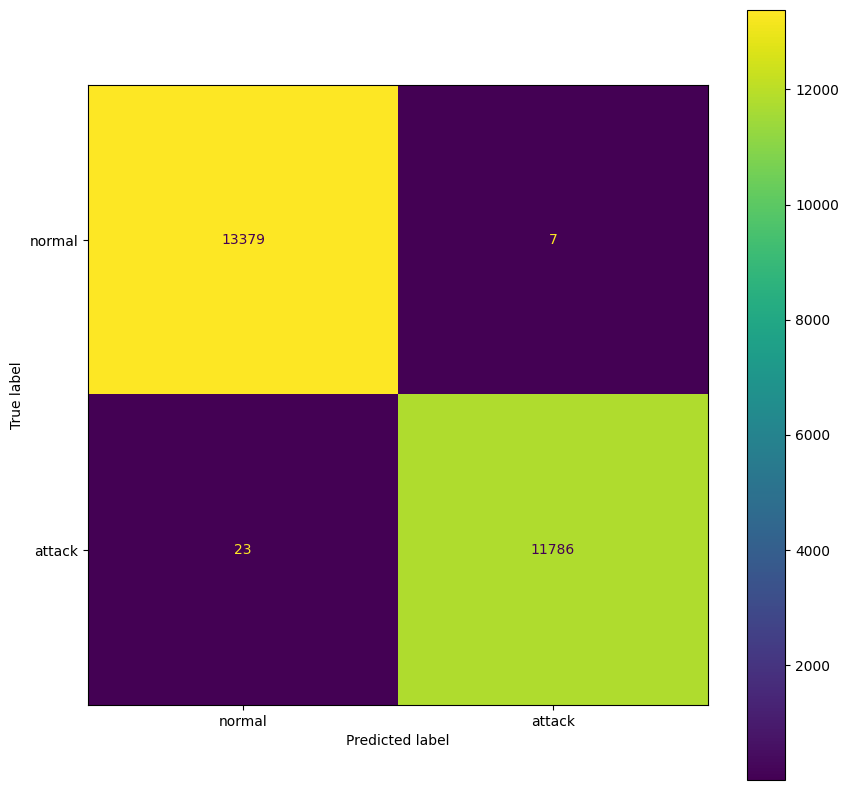

In [16]:
## Random Forest Classifier
rf = RandomForestClassifier().fit(x_train, y_train)
evaluate_classification(rf, "RandomForestClassifier", x_train, x_test, y_train, y_test)

Training Accuracy Logistic Regression 89.40532065848357  Test Accuracy Logistic Regression 89.15260964477079
Training Precesion Logistic Regression 86.6497667815859  Test Precesion Logistic Regression 86.53195942682338
Training Recall Logistic Regression 91.256060314816  Test Recall Logistic Regression 91.0237954102803


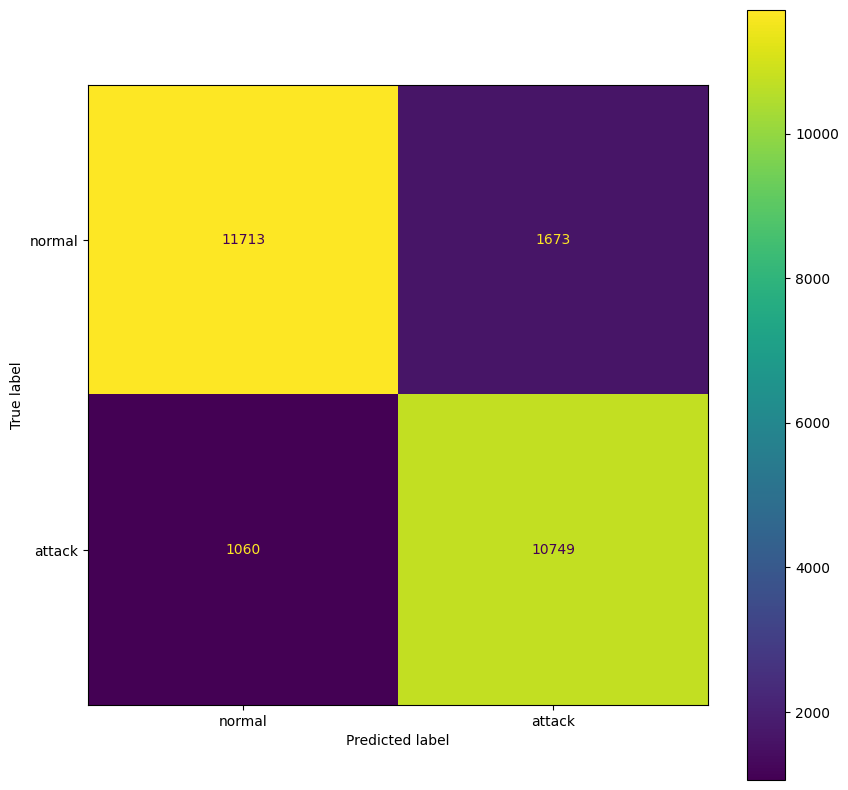

In [17]:
## Logistic Regression
LR= LogisticRegression()
LR.fit(x_train , y_train)
evaluate_classification(LR,'Logistic Regression', x_train, x_test, y_train, y_test)

Training Accuracy Decision Tree Classifier 91.99420502694066  Test Accuracy Decision Tree Classifier 91.68485810676722
Training Precesion Decision Tree Classifier 90.83303479232082  Test Precesion Decision Tree Classifier 90.71931589537223
Training Recall Decision Tree Classifier 92.05911877149143  Test Recall Decision Tree Classifier 91.63349987297823


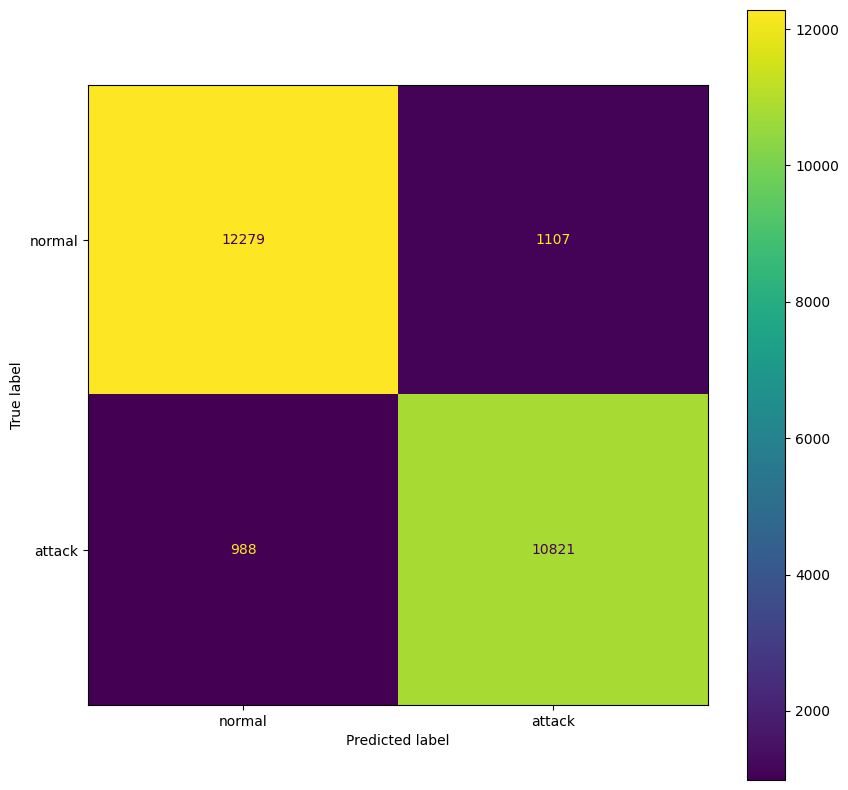

In [18]:
## Decision Tree Classifier
DT =DecisionTreeClassifier(max_features=6, max_depth=4)
DT.fit(x_train, y_train)
evaluate_classification(DT, 'Decision Tree Classifier',  x_train, x_test, y_train, y_test)

Training Accuracy KNN 99.37783422804807  Test Accuracy KNN 99.2339749950387
Training Precesion KNN 99.63894261766603  Test Precesion KNN 99.44662012600034
Training Recall KNN 99.01967066060101  Test Recall KNN 98.91608095520365


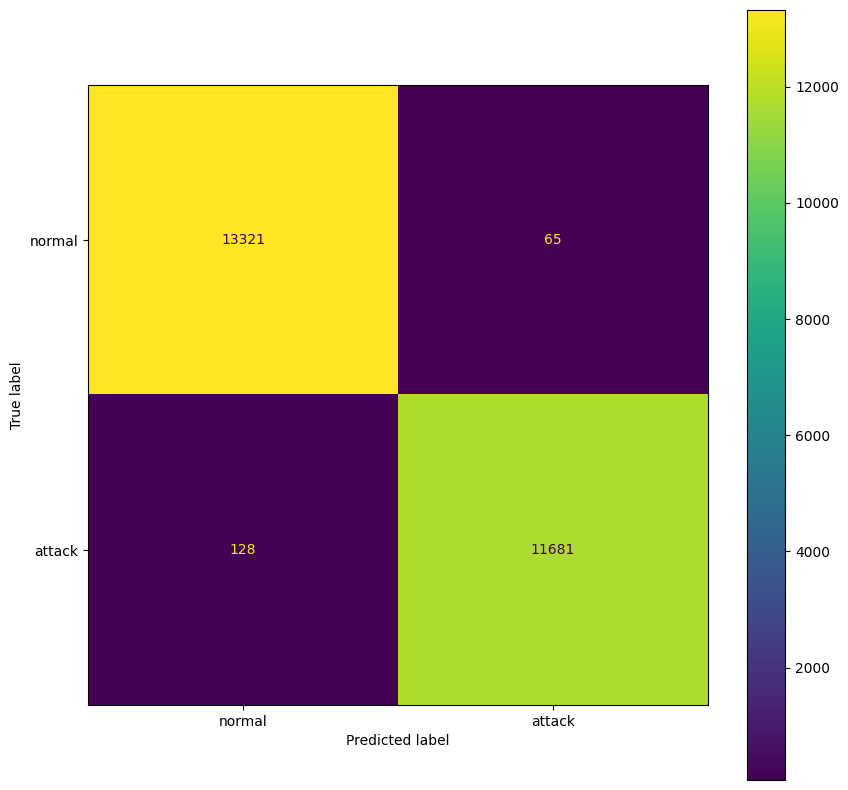

In [19]:
## K Nearest Neighbors
KNN= KNeighborsClassifier(n_neighbors=6) 
KNN.fit(x_train, y_train)
evaluate_classification(KNN, 'KNN', x_train, x_test, y_train, y_test)

Training Accuracy Linear_SVC 97.03503775663098  Test Accuracy Linear_SVC 96.91208573129589
Training Precesion Linear_SVC 96.80512546716497  Test Precesion Linear_SVC 96.4932984911068
Training Recall Linear_SVC 96.81339569851136  Test Recall Linear_SVC 96.93454145143534


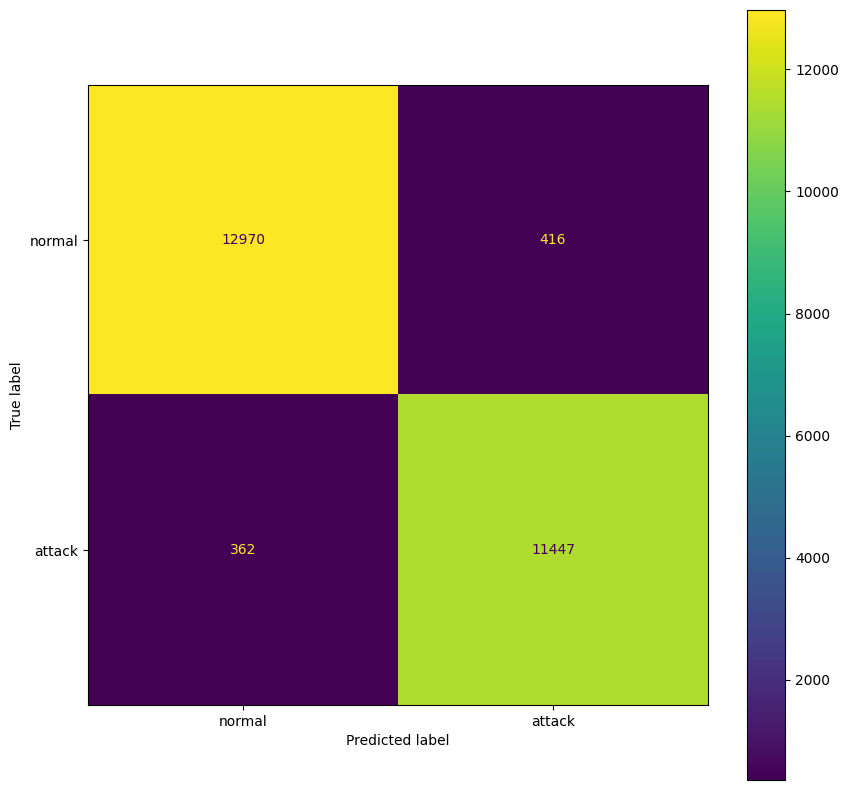

In [20]:
## SVM Classifier
Linear_SVC = svm.LinearSVC(C=1)
Linear_SVC.fit(x_train, y_train)
evaluate_classification(Linear_SVC, 'Linear_SVC', x_train, x_test, y_train, y_test)

Training Accuracy XGBoost 99.98710023120356  Test Accuracy XGBoost 99.90871204604088
Training Precesion XGBoost 99.98291474457544  Test Precesion XGBoost 99.93221487883409
Training Recall XGBoost 99.98932103116123  Test Recall XGBoost 99.87297823693793


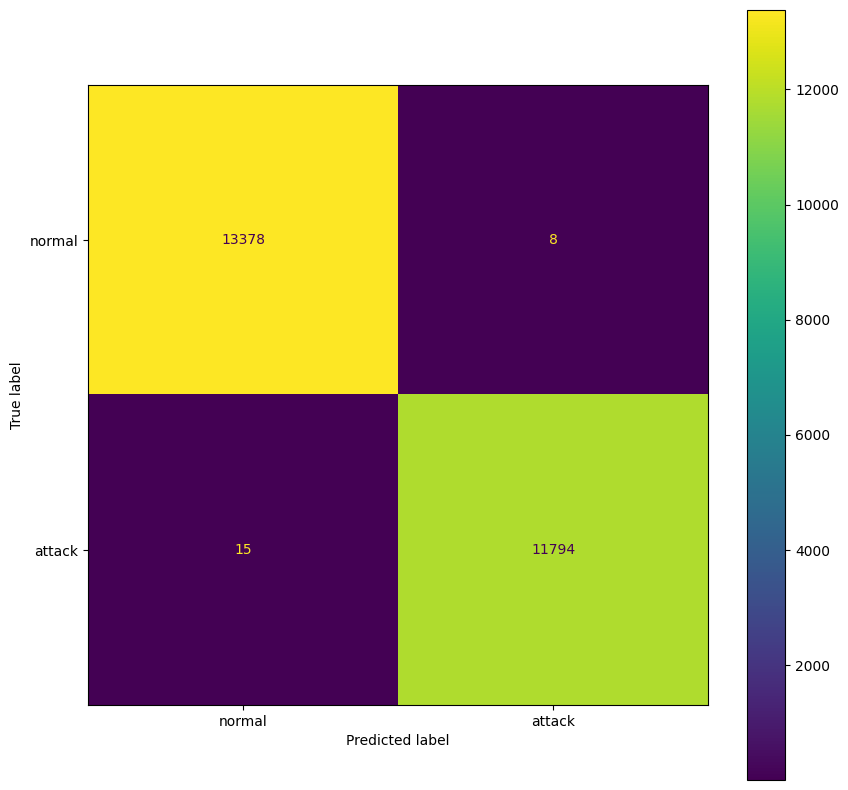

In [21]:
##  Extreme Gradient Boosting (XGBoost) Classifier
XGB = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)
XGB.fit(x_train, y_train)
evaluate_classification(XGB, 'XGBoost', x_train, x_test, y_train, y_test)

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


[LightGBM] [Info] Number of positive: 46821, number of negative: 53956
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3311
[LightGBM] [Info] Number of data points in the train set: 100777, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464600 -> initscore=-0.141837
[LightGBM] [Info] Start training from score -0.141837
Training Accuracy Light Gradient Boosting Machine 99.98511565138871  Test Accuracy Light Gradient Boosting Machine 99.89680492161142
Training Precesion Light Gradient Boosting Machine 99.98504912430585  Test Precesion Light Gradient Boosting Machine 99.91527577734475
Training Recall Light Gradient Boosting Machine 99.98291364985798  Test Recall Light Gradient Boosting Machine 99.86451011940046


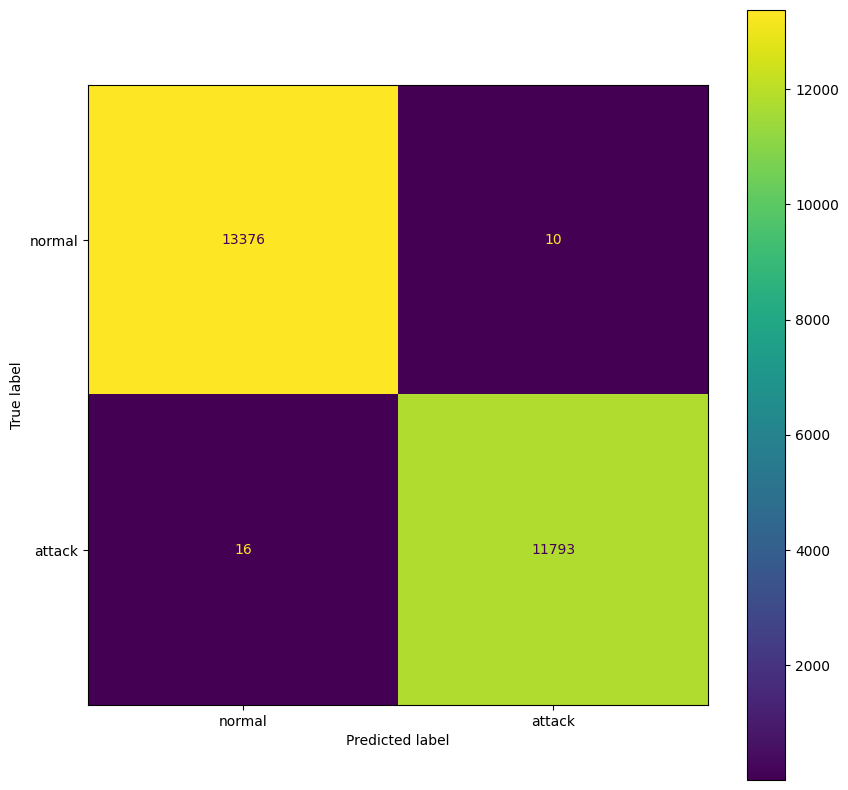

In [22]:
## Light Gradient Boosting Machine (LGBM) Classifier
! pip install lightgbm
import lightgbm as lgb
LGBM = lgb.LGBMClassifier()
LGBM.fit(x_train, y_train)
evaluate_classification(LGBM, 'Light Gradient Boosting Machine', x_train, x_test, y_train, y_test)

0:	learn: 0.4222620	total: 209ms	remaining: 20.7s
1:	learn: 0.2962578	total: 236ms	remaining: 11.6s
2:	learn: 0.2103871	total: 260ms	remaining: 8.4s
3:	learn: 0.1575900	total: 280ms	remaining: 6.71s
4:	learn: 0.1196548	total: 304ms	remaining: 5.77s
5:	learn: 0.0906237	total: 323ms	remaining: 5.06s
6:	learn: 0.0756902	total: 344ms	remaining: 4.57s
7:	learn: 0.0684921	total: 366ms	remaining: 4.21s
8:	learn: 0.0591888	total: 390ms	remaining: 3.94s
9:	learn: 0.0535492	total: 415ms	remaining: 3.73s
10:	learn: 0.0493122	total: 439ms	remaining: 3.55s
11:	learn: 0.0442351	total: 459ms	remaining: 3.37s
12:	learn: 0.0404089	total: 481ms	remaining: 3.22s
13:	learn: 0.0379381	total: 500ms	remaining: 3.07s
14:	learn: 0.0357629	total: 514ms	remaining: 2.91s
15:	learn: 0.0338018	total: 532ms	remaining: 2.79s
16:	learn: 0.0323957	total: 549ms	remaining: 2.68s
17:	learn: 0.0297964	total: 569ms	remaining: 2.59s
18:	learn: 0.0290125	total: 588ms	remaining: 2.5s
19:	learn: 0.0269209	total: 607ms	remaining

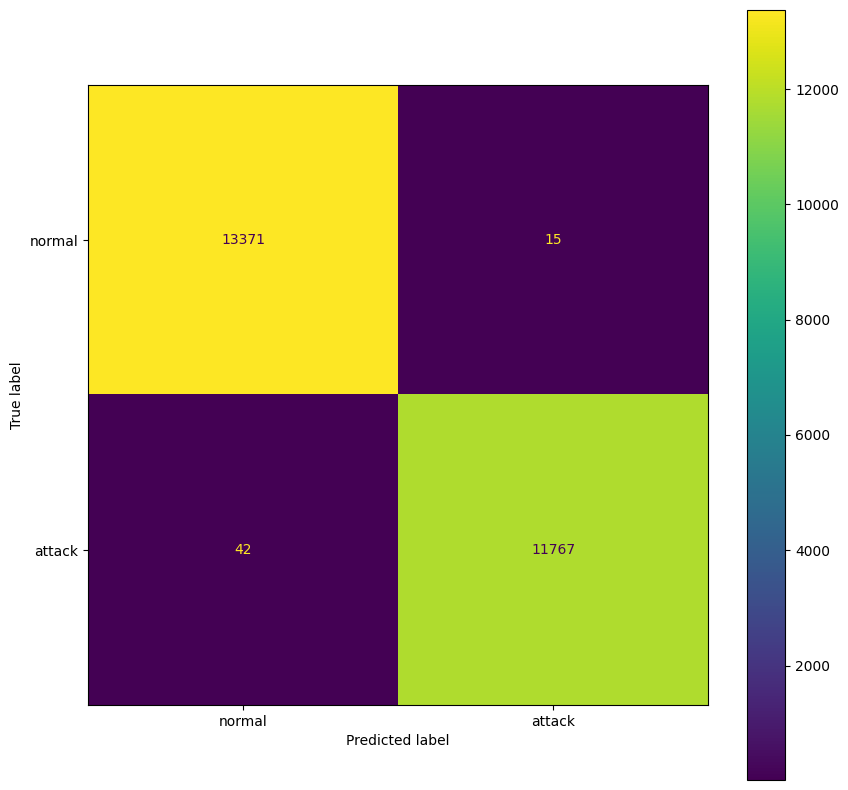

In [15]:
## CatBoost Classifier
from catboost import CatBoostClassifier
CatBoost = CatBoostClassifier(learning_rate=0.1,depth=6,n_estimators=100,l2_leaf_reg=3,subsample=0.8,random_state=42)
CatBoost.fit(x_train, y_train)
evaluate_classification(CatBoost, 'CatBoost Classifier', x_train, x_test, y_train, y_test)

Training Accuracy AdaBoost Classifier 97.65819581849033  Test Accuracy AdaBoost Classifier 97.53919428458028
Training Precesion AdaBoost Classifier 98.76072031760654  Test Precesion AdaBoost Classifier 98.56758399166594
Training Recall AdaBoost Classifier 96.16625018688195  Test Recall AdaBoost Classifier 96.1470065204505


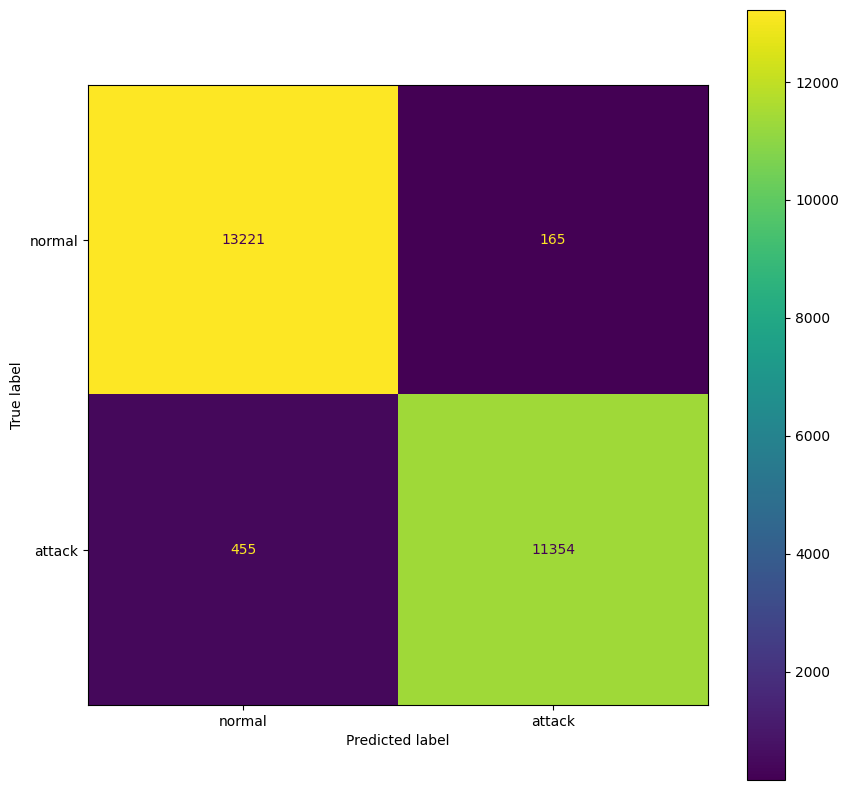

In [14]:
## Adaboost Classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Use a subset of the data for quick iteration
x_train_subset, _, y_train_subset, _ = train_test_split(x_train, y_train, train_size=0.1, stratify=y_train, random_state=42)

# Define the base estimator
base_estimator = DecisionTreeClassifier(max_features=6, max_depth=2)  # Use a shallower tree for faster training

# Instantiate the AdaBoost Classifier with adjusted parameters and parallel processing
AdaBoost = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=0.1)  # Use fewer estimators for faster training
AdaBoost.fit(x_train_subset, y_train_subset)

# Evaluate the classifier
evaluate_classification(AdaBoost, 'AdaBoost Classifier', x_train, x_test, y_train, y_test)


Training Accuracy Ridge Classifier 96.65499072208937  Test Accuracy Ridge Classifier 96.52311966660052
Training Precesion Ridge Classifier 97.68646560428465  Test Precesion Ridge Classifier 97.40698985343855
Training Recall Ridge Classifier 95.05136584011447  Test Recall Ridge Classifier 95.11389618087898


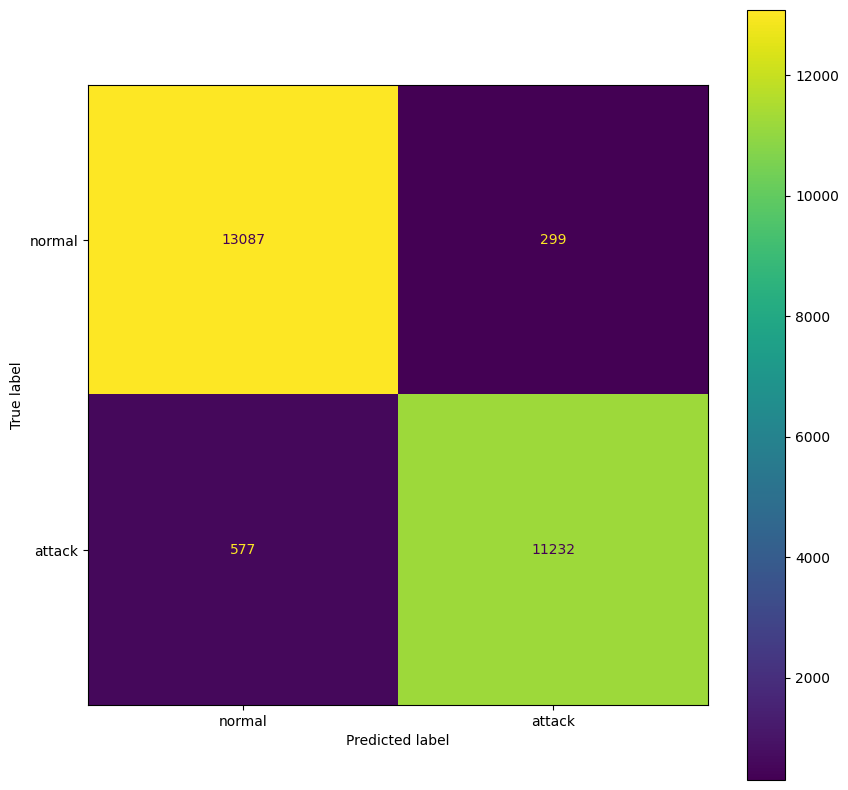

In [11]:
##  Ridge Classifier
from sklearn.linear_model import RidgeClassifier
ridge_classifier = RidgeClassifier(alpha=1.0)  
ridge_classifier.fit(x_train, y_train)
evaluate_classification(ridge_classifier, 'Ridge Classifier', x_train, x_test, y_train, y_test)

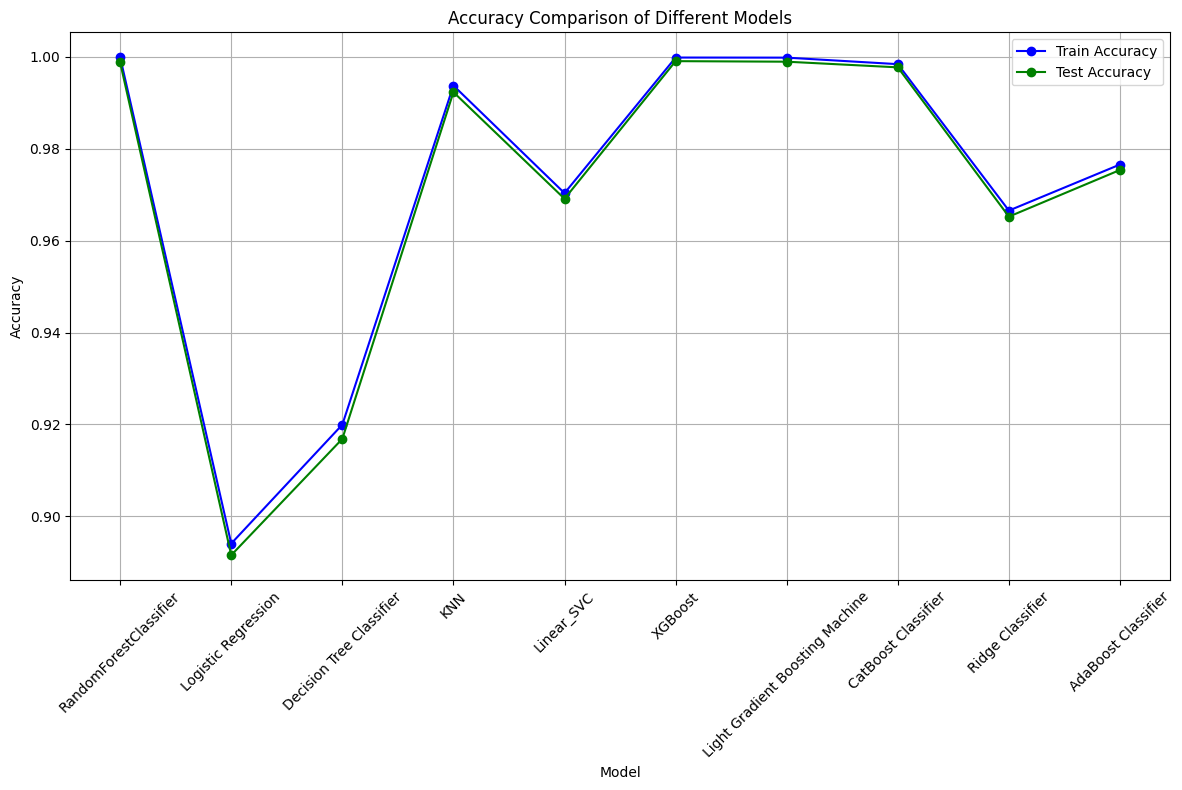

In [24]:

kernal_evals = {
    "RandomForestClassifier": [0.999940, 0.998809, 0.999936, 0.999407, 0.999936, 0.998052],
    "Logistic Regression": [0.894053, 0.891526, 0.866498, 0.865320, 0.912561, 0.910238],
    "Decision Tree Classifier": [0.919942, 0.916849, 0.908330, 0.907193, 0.920591, 0.916335],
    "KNN": [0.993778, 0.992340, 0.996389, 0.994467, 0.990197, 0.989161],
    "Linear_SVC": [0.970350, 0.969121, 0.968051, 0.964933, 0.968134, 0.969345],
    "XGBoost": [0.999871, 0.999087, 0.999829, 0.999322, 0.999893, 0.998730],
    "Light Gradient Boosting Machine": [0.999851, 0.998968, 0.999850, 0.999153, 0.999829, 0.998645],
    "CatBoost Classifier": [0.998432, 0.997738, 0.999315, 0.998727, 0.997309, 0.996443],
    "Ridge Classifier": [0.966550, 0.965231, 0.976865, 0.974070, 0.950514, 0.951139],
    "AdaBoost Classifier": [0.976582, 0.975392, 0.987607, 0.985676, 0.961662, 0.961470]
}
import matplotlib.pyplot as plt

# Extract names and accuracies for plotting
model_names = list(kernal_evals.keys())
train_accuracies = [kernal_evals[name][0] for name in model_names]
test_accuracies = [kernal_evals[name][1] for name in model_names]

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(model_names, train_accuracies, marker='o', label='Train Accuracy', linestyle='-', color='blue')
plt.plot(model_names, test_accuracies, marker='o', label='Test Accuracy', linestyle='-', color='green')

# Adding labels, title, and legend
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
